In [276]:
!pip install mglearn
!pip install preamble

In [277]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

1. Data Exploration and Preprocessing

In [278]:
data = pd.read_csv('/content/drive/MyDrive/Machine Learning/smart_logistics_dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Timestamp                  1000 non-null   object 
 1   Asset_ID                   1000 non-null   object 
 2   Latitude                   1000 non-null   float64
 3   Longitude                  1000 non-null   float64
 4   Inventory_Level            1000 non-null   int64  
 5   Shipment_Status            1000 non-null   object 
 6   Temperature                1000 non-null   float64
 7   Humidity                   1000 non-null   float64
 8   Traffic_Status             1000 non-null   object 
 9   Waiting_Time (min)         1000 non-null   int64  
 10  User_Transaction_Amount $  1000 non-null   int64  
 11  User_Purchase_Frequency    1000 non-null   int64  
 12  Logistics_Delay_Reason     737 non-null    object 
 13  Asset_Utilization %        1000 non-null   float6

In [279]:
data['Logistics_Delay_Reason'] = data['Logistics_Delay_Reason'].fillna('None')
data['Logistics_Delay_Reason']

,Logistics_Delay_Reason
0,Mechanical Failure
1,None
2,None
3,Weather
4,Weather
...,...
995,None
996,Traffic
997,None
998,None


In [280]:
data = data.drop(columns=['Timestamp','Shipment_Status','Asset_ID'])

In [281]:
scaler = StandardScaler()
data['Latitude'] = scaler.fit_transform(data[['Latitude']])
data['Longitude'] = scaler.fit_transform(data[['Longitude']])

In [282]:
data.head(5)

,Latitude,Longitude,Inventory_Level,Temperature,Humidity,Traffic_Status,Waiting_Time (min),User_Transaction_Amount $,User_Purchase_Frequency,Logistics_Delay_Reason,Asset_Utilization %,Demand_Forecast,Logistics_Delay
0,-1.110523,0.645584,303,24.6,68.6,Detour,50,213,6,Mechanical Failure,97.1,297,0
1,-0.242463,0.846418,174,20.2,74.2,Detour,49,403,5,None,83.5,227,1
2,1.734140,-1.709186,179,25.5,70.9,Detour,12,427,9,None,60.3,157,1
3,-1.164001,0.410057,106,26.7,53.3,Detour,39,128,5,Weather,88.0,117,0
4,-0.675892,0.130406,372,20.4,57.2,Clear,29,153,1,Weather,78.2,221,1


In [283]:
features = data.drop(columns=["Logistics_Delay"])
features = pd.get_dummies(features,drop_first=True) #Label Encoded the string values to numberic values
target = 'Logistics_Delay'
X = features
y = data[target]

In [284]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2. Model Selection

In [286]:
#Logistic Regression Model
model1 = LogisticRegression(random_state=42)
model1.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [287]:
#Random Forest Classifier Model
model2 = RandomForestClassifier(random_state=42)
model2.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

3. Model Training

In [288]:
#Cross-validation with KFold
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
def test_model(model, X, y):
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    acc_train, acc_test = [], []

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        y_train_prob = model.predict_proba(X_train)[:, 1]
        y_test_prob = model.predict_proba(X_test)[:, 1]

        acc_train.append(accuracy_score(y_train, y_train_pred))
        acc_test.append(accuracy_score(y_test, y_test_pred))

    print(f"Train Accuracy: {sum(acc_train)/4:.4f}")
    print(f"Test Accuracy:  {sum(acc_test)/4:.4f}")
    print(f"F1 Score:       {f1_score(y_test, y_test_pred):.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_test_pred)}")
    print(f"Classification Report:\n{classification_report(y_test, y_test_pred)}")

    folds = range(1, kf.get_n_splits() + 1)
    plt.plot(folds, acc_train, 'o-', label='Train Accuracy')
    plt.plot(folds, acc_test, 'o-', label='Test Accuracy')
    plt.xlabel("Fold")
    plt.ylabel("Score")
    plt.title("K-Fold Cross Validation Metrics")
    plt.legend()
    plt.grid(True)
    plt.show()

3.1. Train Logistic Regression Model

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Train Accuracy: 0.7183
Test Accuracy:  0.7050
F1 Score:       0.7535
Confusion Matrix:
[[ 73  30]
 [ 40 107]]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68       103
           1       0.78      0.73      0.75       147

    accuracy                           0.72       250
   macro avg       0.71      0.72      0.71       250
weighted avg       0.73      0.72      0.72       250



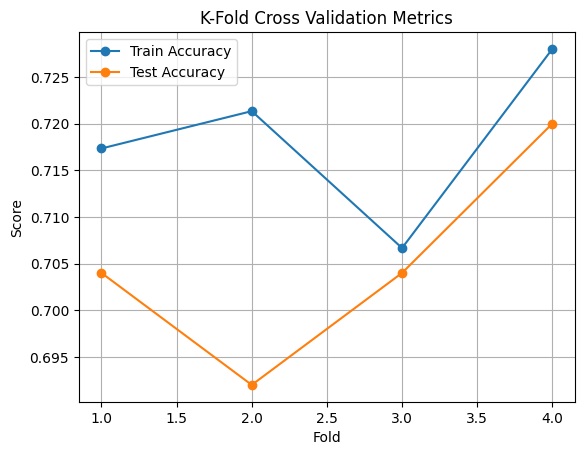

In [289]:
test_model(model1, X,y)

In [290]:
#Tuning model hyperparameters
from sklearn.model_selection import GridSearchCV

model1 = LogisticRegression(solver='liblinear')  # Use solver compatible with small datasets and L1 penalty
param_grid = {
    'C': [0.01, 0.1, 1, 10],               # Regularization strength
    'penalty': ['l1', 'l2'],               # Type of regularization
}
grid_search1 = GridSearchCV(model1, param_grid=param_grid, cv=4, # Use 4-fold cross-validation
                            scoring='accuracy', n_jobs=-1)
grid_search1.fit(X, y)
best_log = grid_search1.best_estimator_
best_log

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

Train Accuracy: 0.7637
Test Accuracy:  0.7630
F1 Score:       0.7542
Confusion Matrix:
[[103   0]
 [ 58  89]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       103
           1       1.00      0.61      0.75       147

    accuracy                           0.77       250
   macro avg       0.82      0.80      0.77       250
weighted avg       0.85      0.77      0.76       250



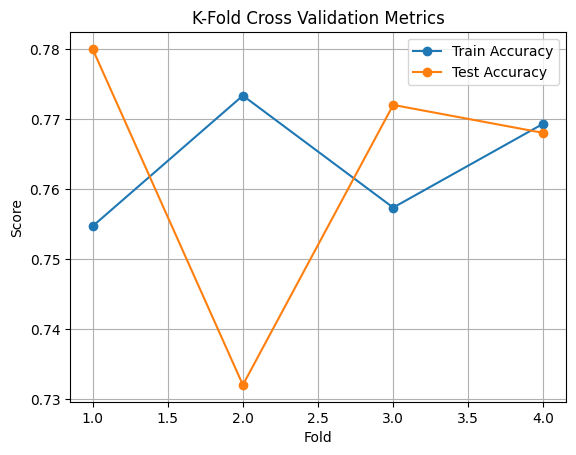

In [291]:
test_model(best_log, X,y)

In [292]:
best_log.fit(X_train,y_train)
y_pred_best_log = best_log.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_best_log)}')
print(f'Confusion matrix:\n{confusion_matrix(y_test, y_pred_best_log)}')
print(f'Classification report:\n{classification_report(y_test, y_pred_best_log)}')

Accuracy: 0.785
Confusion matrix:
[[88  0]
 [43 69]]
Classification report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        88
           1       1.00      0.62      0.76       112

    accuracy                           0.79       200
   macro avg       0.84      0.81      0.78       200
weighted avg       0.86      0.79      0.78       200



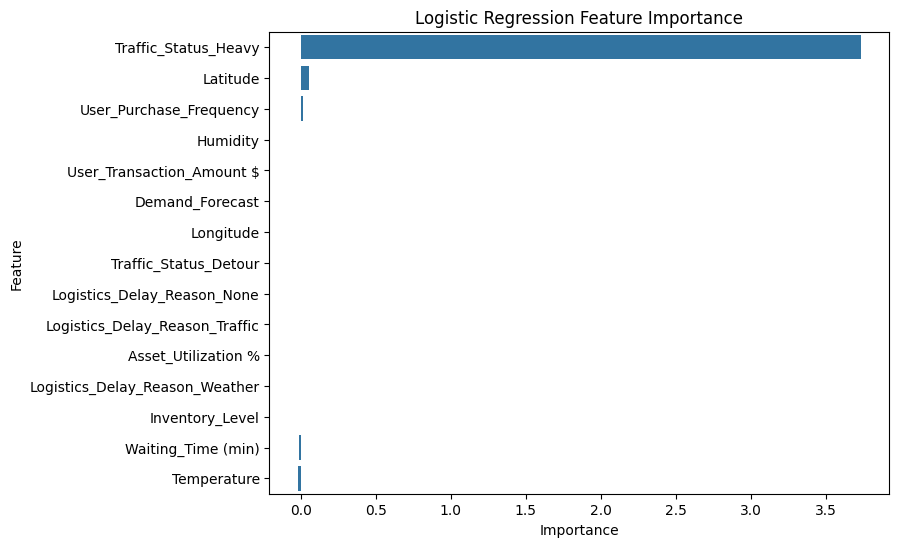

In [293]:
if isinstance(best_log, LogisticRegression):
  importances2 = best_log.coef_[0]
  feature_names = X_train.columns
  feature_importance_rf2 = pd.DataFrame({'Feature': feature_names, 'Importance': importances2})
  feature_importance_rf2 = feature_importance_rf2.sort_values('Importance', ascending=False)
  plt.figure(figsize=(8, 6))
  sns.barplot(x='Importance', y='Feature', data=feature_importance_rf2)
  plt.title('Logistic Regression Feature Importance')
  plt.show()

3.2. Train Random Forest Classifier Model

Train Accuracy: 1.0000
Test Accuracy:  0.7320
F1 Score:       0.7519
Confusion Matrix:
[[ 84  19]
 [ 47 100]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.82      0.72       103
           1       0.84      0.68      0.75       147

    accuracy                           0.74       250
   macro avg       0.74      0.75      0.73       250
weighted avg       0.76      0.74      0.74       250



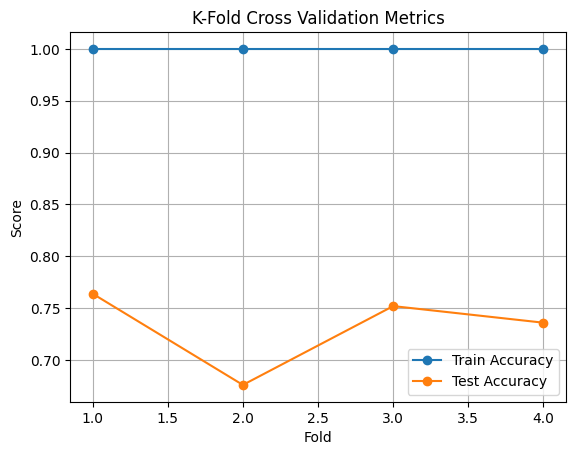

In [294]:
test_model(model2, X,y)

In [295]:
model2 = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [None, 10],
}
grid_search = GridSearchCV(estimator=model2,param_grid=param_grid,
                           cv=4,                        # 4-fold cross-validation
                           scoring='accuracy',
                           n_jobs=-1,verbose=1)
grid_search.fit(X, y)
best_rf = grid_search.best_estimator_
best_rf

Fitting 4 folds for each of 4 candidates, totalling 16 fits


RandomForestClassifier(max_depth=10, n_estimators=250, random_state=42)

Train Accuracy: 0.9927
Test Accuracy:  0.7420
F1 Score:       0.7570
Confusion Matrix:
[[94  9]
 [52 95]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.91      0.76       103
           1       0.91      0.65      0.76       147

    accuracy                           0.76       250
   macro avg       0.78      0.78      0.76       250
weighted avg       0.80      0.76      0.76       250



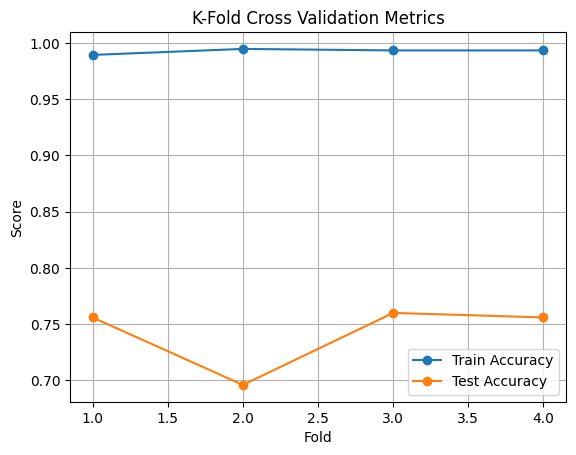

In [296]:
test_model(best_rf, X,y)

In [297]:
best_rf.fit(X_train,y_train)
y_pred_best_rf = best_rf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_best_rf)}')
print(f'Confusion matrix:\n{confusion_matrix(y_test, y_pred_best_rf)}')
print(f'Classification report:\n{classification_report(y_test, y_pred_best_rf)}')

Accuracy: 0.76
Confusion matrix:
[[79  9]
 [39 73]]
Classification report:
              precision    recall  f1-score   support

           0       0.67      0.90      0.77        88
           1       0.89      0.65      0.75       112

    accuracy                           0.76       200
   macro avg       0.78      0.77      0.76       200
weighted avg       0.79      0.76      0.76       200



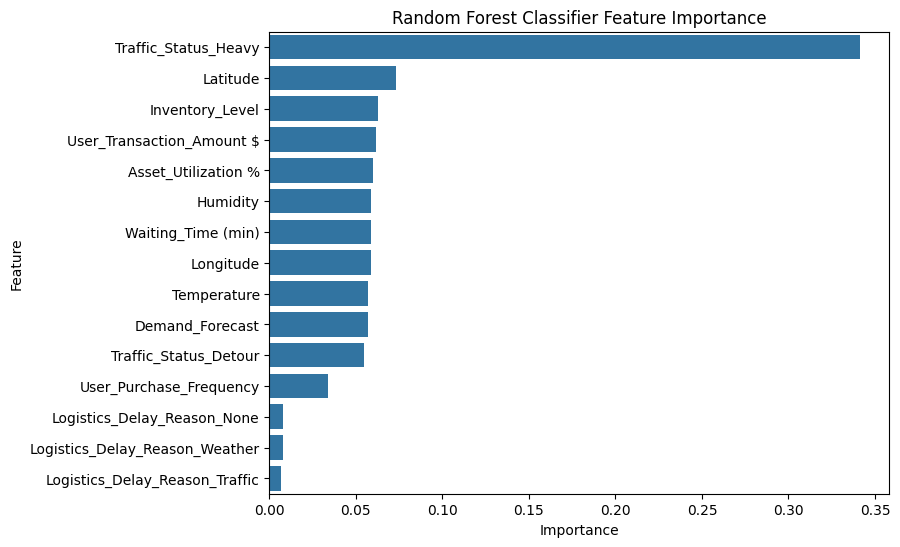

In [298]:
if isinstance(best_rf, RandomForestClassifier):
  importances2 = best_rf.feature_importances_
  feature_names = X_train.columns
  feature_importance_rf2 = pd.DataFrame({'Feature': feature_names, 'Importance': importances2})
  feature_importance_rf2 = feature_importance_rf2.sort_values('Importance', ascending=False)
  plt.figure(figsize=(8, 6))
  sns.barplot(x='Importance', y='Feature', data=feature_importance_rf2)
  plt.title('Random Forest Classifier Feature Importance')
  plt.show()

In [299]:
top_features = features[[
    'Traffic_Status_Heavy', 'Inventory_Level','Longitude','Humidity','Temperature',
    'Demand_Forecast','Latitude','Waiting_Time (min)']]

x = top_features
y = data[target]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
top_feature_rf = best_rf
top_feature_rf.fit(x_train, y_train)
y_pred_top_rf = top_feature_rf.predict(x_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred_top_rf)}')
print(f'Confusion matrix:\n{confusion_matrix(y_test, y_pred_top_rf)}')
print(f'Classification report:\n{classification_report(y_test, y_pred_top_rf)}')

Accuracy: 0.765
Confusion matrix:
[[78 10]
 [37 75]]
Classification report:
              precision    recall  f1-score   support

           0       0.68      0.89      0.77        88
           1       0.88      0.67      0.76       112

    accuracy                           0.77       200
   macro avg       0.78      0.78      0.76       200
weighted avg       0.79      0.77      0.76       200



In [300]:
top_feature_log = best_log
top_feature_log.fit(x_train, y_train)
y_pred_top_log = top_feature_log.predict(x_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred_top_log)}')
print(f'Confusion matrix:\n{confusion_matrix(y_test, y_pred_top_log)}')
print(f'Classification report:\n{classification_report(y_test, y_pred_top_log)}')

Accuracy: 0.785
Confusion matrix:
[[88  0]
 [43 69]]
Classification report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        88
           1       1.00      0.62      0.76       112

    accuracy                           0.79       200
   macro avg       0.84      0.81      0.78       200
weighted avg       0.86      0.79      0.78       200



Predicted Logistics Delay: Yes
Probability of Delay: 0.5120


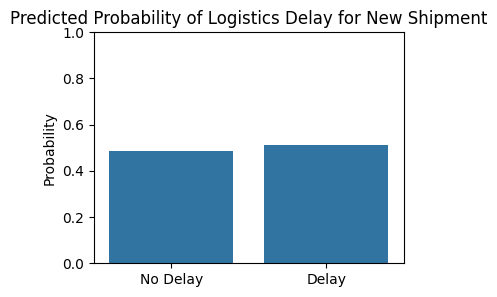

In [301]:
trained_features = top_features.columns.tolist()
new_shipment_data_scaled = {}
new_shipment_data = {feature: 0 for feature in trained_features}
new_shipment_data.update({
    "Latitude": 1.7128,
    "Longitude": -1.0060,
    "Inventory_Level": 500,
    "Temperature": 40.0,
    "Humidity": 10.0,
    "Waiting_Time": 30,
    "Demand_Forecast": 250,
    "Traffic_Status_Heavy": 0,
})
# Convert to DataFrame with correct column order
new_shipment_df = pd.DataFrame([new_shipment_data], columns=trained_features)

# Predict whether this shipment will be delayed
predicted_delay = top_feature_rf.predict(new_shipment_df)[0]
predicted_delay_prob = top_feature_rf.predict_proba(new_shipment_df)[0][1]
# Show the prediction result
print(f"Predicted Logistics Delay: {'Yes' if predicted_delay == 1 else 'No'}")
print(f"Probability of Delay: {predicted_delay_prob:.4f}")

plt.figure(figsize=(4, 3))
sns.barplot(x=['No Delay', 'Delay'], y=[1 - predicted_delay_prob, predicted_delay_prob])
plt.ylabel('Probability')
plt.title('Predicted Probability of Logistics Delay for New Shipment')
plt.ylim(0, 1)
plt.show()

Predicted Logistics Delay: No
Probability of Delay: 0.3865


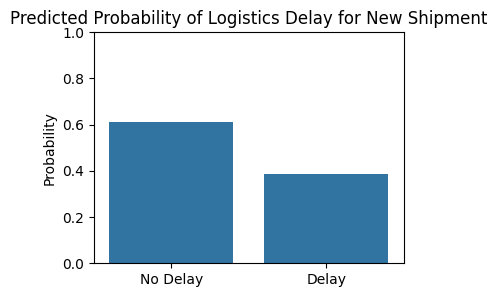

In [302]:
trained_features = top_features.columns.tolist()
new_shipment_data_scaled = {}
new_shipment_data = {feature: 0 for feature in trained_features}
new_shipment_data.update({
    "Latitude": 1.7128,
    "Longitude": -1.0060,
    "Inventory_Level": 500,
    "Temperature": 40.0,
    "Humidity": 60.0,
    "Waiting_Time": 30,
    "Demand_Forecast": 250,
    "Traffic_Status_Heavy": 0,
})
# Convert to DataFrame with correct column order
new_shipment_df = pd.DataFrame([new_shipment_data], columns=trained_features)

# Predict whether this shipment will be delayed
predicted_delay = top_feature_log.predict(new_shipment_df)[0]
predicted_delay_prob = top_feature_log.predict_proba(new_shipment_df)[0][1]
# Show the prediction result
print(f"Predicted Logistics Delay: {'Yes' if predicted_delay == 1 else 'No'}")
print(f"Probability of Delay: {predicted_delay_prob:.4f}")

plt.figure(figsize=(4, 3))
sns.barplot(x=['No Delay', 'Delay'], y=[1 - predicted_delay_prob, predicted_delay_prob])
plt.ylabel('Probability')
plt.title('Predicted Probability of Logistics Delay for New Shipment')
plt.ylim(0, 1)
plt.show()